In [1]:
import numpy as np
import h5py
from astropy.io import fits
from scipy import optimize
import emcee
from astropy import constants as const
import matplotlib.pyplot as plt


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'


### (1) Read hdf5 file
### (2) Stack with center peak matched $w_{\rm ur}$ and normalizing to the narrow tomo bin angular cross-correlation function $\hat{w}_{\rm ur}(z_j)$ across wide tomo bin. The jackknife resampling is also performed in this step.  

In [2]:
def load_wur_data(filename):
    """
    Load the data saved from step 1.

    Parameters:
    - filename: Name of the HDF5 file to load.

    Returns:
    - data: Dictionary containing the loaded data arrays.
    """
    with h5py.File(filename, 'r') as hf:
        #rbins = hf['rbins'][:]
        #dr_bins = hf['dr_bins'][:]
        #rbins_cen = hf['rbins_cen'][:]
        z_i_bins = hf['z_i_bins'][:]
        z_j_bins = hf['z_j_bins'][:]
        wDuDr = hf['wDuDr'][:]
        wDuRr = hf['wDuRr'][:]
        Nr = hf['Nr'][:]
        Rr = hf['Rr'][:]
        jk_patch_labels = hf['jk_patch_labels'][:]
    return {
        #'rbins': rbins,
        #'dr_bins': dr_bins,
        #'rbins_cen': rbins_cen,
        'z_i_bins': z_i_bins,
        'z_j_bins': z_j_bins,
        'wDuDr': wDuDr,
        'wDuRr': wDuRr,
        'Nr': Nr,
        'Rr': Rr,
        'jk_patch_labels': jk_patch_labels
    }

def cen_match(z_cen, n_stacking, z_j_bins_cen):
    """
    Match the center of w_ur and select N points of z_j to perform the stacking.

    Parameters:
    - z_cen: Target redshift.
    - n_stacking: Number of z_j bins to stack over (should be an odd number).
    - z_j_bins_cen: Array of z_j bin centers.

    Returns:
    - start_idx: Start index for stacking.
    - end_idx: End index (exclusive) for stacking.
    - center_idx: Index of z_j_bins_cen closest to z_cen.
    """
    # Ensure n_stacking is an odd number
    if n_stacking % 2 == 0:
        raise ValueError("n_stacking must be an odd number.")

    # Find the index of z_j_bins_cen closest to z_cen
    center_idx = np.argmin(np.abs(z_j_bins_cen - z_cen))

    half_n = n_stacking // 2
    start_idx = center_idx - half_n
    end_idx = center_idx + half_n + 1  # +1 because end_idx is exclusive in slicing

    # Adjust indices if they go beyond the array bounds
    if start_idx < 0:
        # Shift the window forward
        end_idx += -start_idx
        start_idx = 0
        end_idx = min(end_idx, len(z_j_bins_cen))
    elif end_idx > len(z_j_bins_cen):
        # Shift the window backward
        start_idx -= end_idx - len(z_j_bins_cen)
        end_idx = len(z_j_bins_cen)
        start_idx = max(start_idx, 0)

    # Ensure that we have the correct number of stacking points
    current_n = end_idx - start_idx
    if current_n != n_stacking:
        # Adjust start_idx or end_idx if possible
        if start_idx == 0 and end_idx < len(z_j_bins_cen):
            end_idx = start_idx + n_stacking
        elif end_idx == len(z_j_bins_cen) and start_idx > 0:
            start_idx = end_idx - n_stacking

    return start_idx, end_idx, center_idx


    
def jk_covmat_new(jnum, npatchs, w_jk):
    mean_w_jk = np.mean(w_jk, axis=1)
    jk_covmatrix_w = np.zeros((jnum, jnum))
    for j1 in range(jnum):
        for j2 in range(jnum):
            diff_j1 = w_jk[j1, :] - mean_w_jk[j1]
            diff_j2 = w_jk[j2, :] - mean_w_jk[j2]
            jk_covmatrix_w[j1, j2] = (npatchs - 1)/npatchs * np.sum(diff_j1 * diff_j2)
    jkerr = np.sqrt(np.diag(jk_covmatrix_w))
    return mean_w_jk, jkerr, jk_covmatrix_w


# --------------------------------------------------------------------------------
# Load correlation-function wur
# --------------------------------------------------------------------------------

#  i_dzi     =          2    3     4     5      
# zmin_i_arr = [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]
# zmax_i_arr = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75]

i_dzi  = 3 #0
dz_i = 0.0025

zmin_i = 0.45
zmax_i = 0.50
filename = f'../wDuDr_wDuRr_zj005_zi0025_spatial_{zmin_i:.3f}_{zmax_i:.3f}_lam4.h5'
data_all = load_wur_data(filename)

z_i_bins    = data_all['z_i_bins']
z_j_bins    = data_all['z_j_bins']
z_j_bins_cen= 0.5*(z_j_bins[:-1] + z_j_bins[1:])
dz_j        = z_j_bins[1]-z_j_bins[0]

wDuDr       = data_all['wDuDr']   # shape: (n_zibins, n_zjbins, K)
wDuRr       = data_all['wDuRr']
Nr          = data_all['Nr']
Rr          = data_all['Rr']
jk_labels   = data_all['jk_patch_labels']
K           = len(jk_labels)      # number of jackknife subsamples

n_stacking = 67   # should be odd for the symmetric bins around the central bin

# build stacked slices aligned to each z_i bin center
wDuDr_selected = np.zeros((len(z_i_bins), n_stacking, K))
wDuRr_selected = np.zeros((len(z_i_bins), n_stacking, K))
Nr_selected    = np.zeros((len(z_i_bins), n_stacking, K))
Rr_selected    = np.zeros((len(z_i_bins), n_stacking, K))
zj_cen_skdbins = np.zeros((len(z_i_bins), n_stacking))

for i in range(len(z_i_bins)-1):
    zi_cen = 0.5*(z_i_bins[i] + z_i_bins[i+1])
    sidx, eidx, cidx = cen_match(zi_cen, n_stacking, z_j_bins_cen)

    zj_cen_skdbins[i,:]  = (
        z_j_bins_cen[sidx:eidx] - z_j_bins_cen[cidx]
    )
    wDuDr_selected[i,:,:] = wDuDr[i, sidx:eidx, :]
    wDuRr_selected[i,:,:] = wDuRr[i, sidx:eidx, :]
    Nr_selected[i,:,:]    = Nr[i,   sidx:eidx, :]
    Rr_selected[i,:,:]    = Rr[i,   sidx:eidx, :]

# average over z_i bins to get a single profile per JK patch
wDuDr_skdmean = np.mean(wDuDr_selected, axis=0)   # (J, K)
wDuRr_skdmean = np.mean(wDuRr_selected, axis=0)   # (J, K)
Nr_skdmean    = np.mean(Nr_selected,    axis=0)   # (J, K)
Rr_skdmean    = np.mean(Rr_selected,    axis=0)   # (J, K)

J = n_stacking

wur_skdmean      = np.zeros((J, K))
wur_skdmean_norm = np.zeros((J, K))
for kk in range(K):
    wur_skdmean[:,kk] = (
        Rr_skdmean[:,kk]/Nr_skdmean[:,kk] * (wDuDr_skdmean[:,kk]/wDuRr_skdmean[:,kk]) - 1.0
    )
    # normalize to unit area in z
    norm = np.sum(wur_skdmean[:,kk])*dz_j
    wur_skdmean_norm[:,kk] = wur_skdmean[:,kk] / norm

# jackknife covariance in *unprojected* space, mostly for sanity check (not used later)
wur_mean, wur_err, covariance_matrix = jk_covmat_new(J, K, wur_skdmean_norm)




## Plot the covariance matrix.

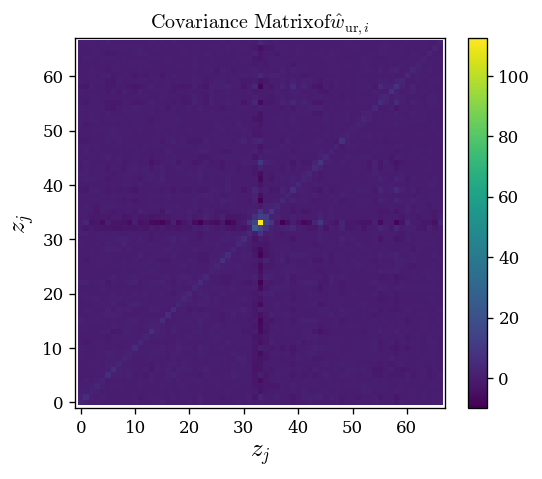

In [3]:

fig, ax = plt.subplots(figsize=(5,4), dpi=120) #plt.figure(figsize=(6,5),dpi=200)

# data_covmat = covariance_matrix
cbar= ax.matshow(covariance_matrix)
# ax.gca().xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.set_xlabel(r'$z_j$', fontsize=15)
ax.set_ylabel(r'$z_j$', fontsize=15)

ax.set_xlim(-1,n_stacking)
ax.set_ylim(-1,n_stacking)
plt.colorbar(cbar, ax=ax)
ax.set_title(r'$\rm Covariance \ Matrix of \it \hat{w}_{\rm ur,\it i}$')

plt.show()


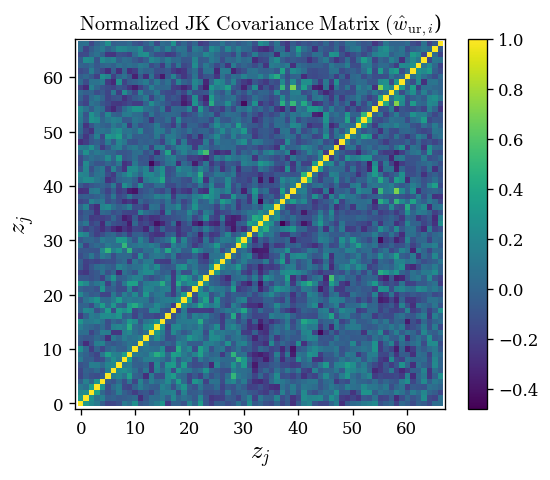

In [4]:
def normalize_diagonal(matrix):
    """Normalizes the matrix so that diagonal values are 1."""
    new_matrix = np.zeros((n_stacking,n_stacking))#matrix / row_sums[:, np.newaxis]
    for i in range(n_stacking):
        for j in range(n_stacking):
            new_matrix[i,j] = matrix[i,j]/np.sqrt(matrix[i,i]*matrix[j,j])
    return new_matrix

fig, ax = plt.subplots(figsize=(5,4), dpi=120) #plt.figure(figsize=(6,5),dpi=200)


data_covmat_norm = normalize_diagonal(covariance_matrix) #covariance_matrix_shrunked
cbar= ax.matshow(data_covmat_norm)
# ax.gca().xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.set_xlabel(r'$z_j$', fontsize=15)
ax.set_ylabel(r'$z_j$', fontsize=15)

ax.set_xlim(-1,n_stacking)
ax.set_ylim(-1,n_stacking)
plt.colorbar(cbar, ax=ax)
ax.set_title(r'$\rm Normalized \ JK \ Covariance \ Matrix \ \it (\hat{w}_{\rm ur,\it i}$)')
plt.show()

In [5]:
def gal_narrow_bins(n_gals, z_narrow_bins, z_narrow_bins_cen, nz_nbins,
                    z_lambda, z_spec, z_j_bins, z_j_bins_cen):
    
    gal_zspec = np.zeros((nz_nbins, n_gals))
    gal_zjbin_center = np.zeros((nz_nbins, n_gals))
    iz_cnts = 0
    for i in range(nz_nbins):    
        ### For unknown galaxies with zspec_true
        stag_g, etag_g, tag_cen_g = cen_match(z_narrow_bins_cen[i], n_gals, z_j_bins_cen)
        seltag = (z_lambda>=z_narrow_bins[i])&(z_lambda<z_narrow_bins[i+1])

        zspec_t = z_spec[seltag]
        
        # print(i,'zspec_t',len(zspec_t)) ### There is no member galaxy in for some richness bins 
        if len(zspec_t)>10:
            iz_cnts += 1
            zspec_red_tnum, xbins = np.histogram(zspec_t,z_j_bins,density=True)
            zspec_red_tnum_sel = zspec_red_tnum[stag_g:etag_g]
            gal_zspec[i,:] = zspec_red_tnum_sel
            gal_zjbin_center[i,:] = z_j_bins_cen[stag_g:etag_g]-z_j_bins_cen[tag_cen_g]

    gal_mean_znbins = np.zeros(n_gals)
    for i in range(nz_nbins):
        gal_mean_znbins[:] += gal_zspec[i,:]


    gal_err_znbins = np.zeros(n_gals)
    for i in range(n_gals):
        gal_err_znbins[i] = np.std(gal_zspec[:,i])
    return gal_zjbin_center[0,:], gal_mean_znbins/float(iz_cnts), gal_err_znbins



def stacked_bins_tag(nstacked_bins, z_narrow_bins):
    n_znbins  = len(z_narrow_bins)-1
    n_skd_wur = round(n_znbins/float(nstacked_bins))
    ii_start = []
    ii_end   = []
    skd_bins_ss = []
    skd_bins_ee = []
    for k in range(n_skd_wur):
        i_start = k*nstacked_bins
        if k != n_skd_wur-1:
            i_end = (k+1)*nstacked_bins
        else:
            i_end = n_znbins
        ii_start.append(i_start)
        ii_end.append(i_end)
        skd_bins_ss.append(z_narrow_bins[i_start])
        skd_bins_ee.append(z_narrow_bins[i_end])
    return np.array(ii_start), np.array(ii_end), np.array(skd_bins_ss), np.array(skd_bins_ee)


# --------------------------------------------------------------------------------
# Load redmapper stacks just to define iz_center_tag, etc.
# (You already did this; I'll keep that logic structurally.)
# --------------------------------------------------------------------------------

pathz = '/lustre/work/client/users/lyang4/borah_scratch/data/redmapper_run_chisq_max_8/'
fname = pathz + 'newmatched_zspec_median_clusters_chisq_max_8_Cardinal-3Y6a_run_redmapper_v0.8.5_lgt20_vl02_catalog_members_p078.fit'

with fits.open(fname) as hdul:
    hdul.verify('fix')
    data_z = hdul[1].data

richness = data_z['lambda']
sel_gal = (richness>=45) 
z_lambda = data_z['zspec_median_p07'][sel_gal]
z_spec   = data_z['zspec'][sel_gal]
richness = data_z['lambda'][sel_gal]

dvminf = zmin_i
dvmaxf = zmax_i
dz_i   = 0.0025
znarrow_bins = np.arange(dvminf, dvmaxf+dz_i, dz_i)

skd_znbins = 20
i_st, i_ed, st_bins, ed_bins = stacked_bins_tag(skd_znbins, znarrow_bins)
num_skd_bins = len(i_st)

iz_center_tag = np.zeros(num_skd_bins)
n_sk_wur   = num_skd_bins
n_points   = n_stacking
gal_zj_cen = np.zeros(n_points)
gal_mean_zjnbins = np.zeros(n_points)
gal_err_zjnbins  = np.zeros(n_points)

# for ii in range(n_sk_wur):
iz_center_tag = 0.5*(st_bins + ed_bins)
znarrow_bins_ii = np.arange(st_bins, ed_bins+dz_i, dz_i)
print("znarrow_bins_ii",znarrow_bins_ii)
print(80*'-')
znarrow_bins_cen_ii = 0.5 * (znarrow_bins_ii[1:] + znarrow_bins_ii[:-1])
n_znbins_sel = len(znarrow_bins_cen_ii)
print("znarrow_bins_cen_ii", znarrow_bins_cen_ii)
print(80*'-')
gzc, gmean, gerr = gal_narrow_bins(
    n_points,
    znarrow_bins_ii,
    znarrow_bins_cen_ii,
    n_znbins_sel,
    z_lambda, z_spec,
    z_j_bins,
    z_j_bins_cen
)
gal_zj_cen       = gzc
gal_mean_zjnbins = gmean
gal_err_zjnbins  = gerr



znarrow_bins_ii [0.45   0.4525 0.455  0.4575 0.46   0.4625 0.465  0.4675 0.47   0.4725
 0.475  0.4775 0.48   0.4825 0.485  0.4875 0.49   0.4925 0.495  0.4975
 0.5   ]
--------------------------------------------------------------------------------
znarrow_bins_cen_ii [0.45125 0.45375 0.45625 0.45875 0.46125 0.46375 0.46625 0.46875 0.47125
 0.47375 0.47625 0.47875 0.48125 0.48375 0.48625 0.48875 0.49125 0.49375
 0.49625 0.49875]
--------------------------------------------------------------------------------


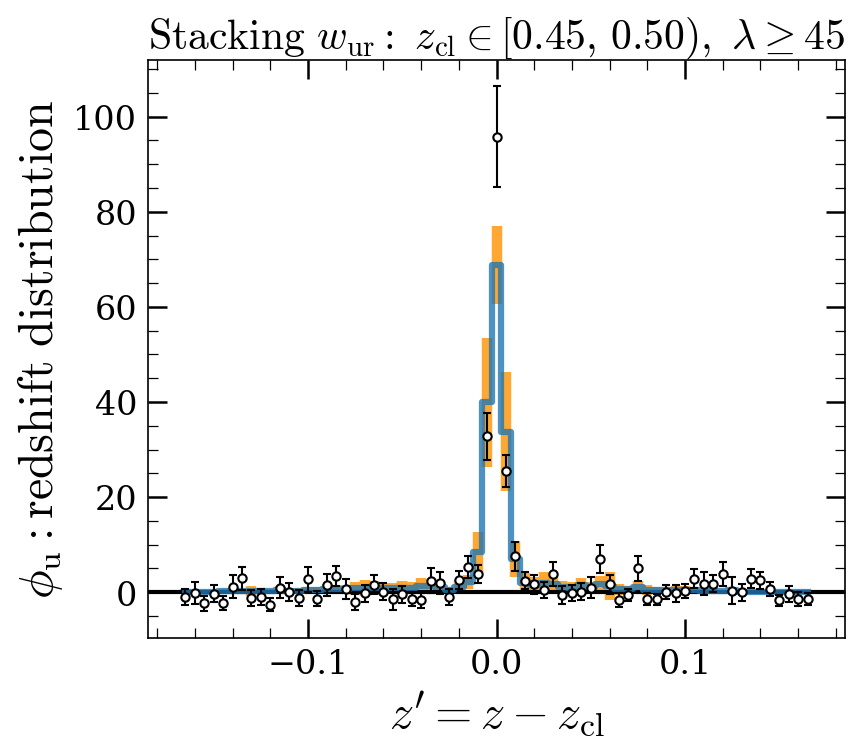

In [6]:
fig = plt.figure(figsize=(6,5),dpi=150)

plt.errorbar(gal_zj_cen,
             gal_mean_zjnbins,
             yerr = gal_err_zjnbins,
             #marker = '.',
             drawstyle = 'steps-mid',lw=3,alpha=0.8, ecolor='#FF9100',
             elinewidth=5)

plt.errorbar(zj_cen_skdbins[0,:], ### shape: [21, 67]
             wur_mean, 
             yerr = wur_err,
             fmt='o',ms=4, alpha=1, elinewidth=1, capsize=2,
             mfc='white', color='black', zorder=3,
             label=r"Normalized stacking w$_{ur}$")#"\n"

plt.plot([-1.,1.],[0,0],'k-',lw=2)

plt.xlim(-0.185,0.185)

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 

plt.title(rf"$\rm Stacking \ \it w_{{\rm ur}}: \ z_{{\rm cl}} \in [{zmin_i:.2f},\,{zmax_i:.2f}), \ \lambda \geq 45 $", 
          fontsize=20)


plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=16, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()

## (3) Projection to remove the normalization mode, which remove one degree of freedom J -> J-1. 
## (4) In sample space, we use a diagonal-target shrinkage and assume Sellentin-Heavens Student-$t$ likelihood for fitting.
## (4) We use the double-Gaussian model to provide an initial prediction for the best-fit parameters using MCMC inputs.

In [31]:
def shrink_to_diag(Cs, lam):
    # diagonal-target shrinkage
    T_diag = np.diag(np.diag(Cs))
    C = (1-lam)*Cs + lam*T_diag
    C = 0.5*(C + C.T)
    return C

def twoGaussian_func(x, mu, sigma, sigma2, amp2):
    # (1-amp2)*narrow Gaussian + amp2*broad Gaussian
    G1 = (1-amp2)*np.exp(-(x-mu)**2/(2*sigma**2)) / (sigma*np.sqrt(2*np.pi))
    G2 = amp2*np.exp(-(x-mu)**2/(2*sigma2**2))    / (sigma2*np.sqrt(2*np.pi))
    return G1 + G2

def vdisp_to_dz(redshift, veldisp_kms):
    # convert velocity dispersion (km/s) to dz at this redshift
    return veldisp_kms*(1+redshift)/const.c.to('km/s').value


# --------------------------------------------------------------------------------
# Build projection matrix P
# --------------------------------------------------------------------------------

w_mode = np.ones(J) * np.sqrt(dz_j)
w_mode = w_mode / np.linalg.norm(w_mode)
P = np.eye(J) - np.outer(w_mode, w_mode)

# project data mean and each JK column
data_vec  = wur_mean        # shape (J,)
dataP     = P @ data_vec    # projected data
X         = wur_skdmean_norm  # J x K
XP        = (P @ X).T         # K x J  (rows = samples)

# sample covariance of projected JK realizations
C_sample = np.cov(XP, rowvar=False, bias=False)  # J x J
C_sample = 0.5*(C_sample + C_sample.T)

# jackknife scaling factor
jk_factor = (K - 1)**2 / K

### choose a shrinkage level λ
# have tried lams = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0] and 
# pick the lam which gives the lowest reduced chi2 in the confidence region [1, 1.5]
lam = 0.8  
print('****** lam', lam, "******")
# shrink sample covariance toward its diagonal, then scale to JK units
C_fit_sample = shrink_to_diag(C_sample, lam)  # this is in sample units
C_fit = jk_factor * C_fit_sample              # now in jackknife units

# add tiny ridge for numerical stability (JK units)
ridge = 1e-8 * np.trace(C_fit) / (J - 1)
C_fit = C_fit + ridge * np.eye(J)

Cinv_fit = np.linalg.inv(C_fit)

# --------------------------------------------------------------------------------
# Build model, chi2, priors
# --------------------------------------------------------------------------------

x  = zj_cen_skdbins[i_dzi,:]   # shape: (J,)

def chisq_projected(params):
    mu1, sigma1, sigma2, amp2 = params
    model = twoGaussian_func(x, mu1, sigma1, sigma2, amp2)
    r = (P @ model) - dataP
    return r @ (Cinv_fit @ r)

# physically motivated initial guesses
stacked_iz_center = iz_center_tag 
print("********** stacked_iz_center ",stacked_iz_center,"*********")

dz_603   = vdisp_to_dz(stacked_iz_center, 747.63654) # min(dz_sigmav) see appendixA
dz_1063  = vdisp_to_dz(stacked_iz_center, 1505.4343) # max(dz_sigmav) 

vp603_dz  = np.sqrt(dz_603**2  + dz_i**2)
vp1063_dz = np.sqrt(dz_1063**2 + dz_i**2)

### sigma_cl
sig1_min   = 0.001 ### not use dz_j or dz_i, the fitting is not sensitive to this range 
sig1_max   = 0.01  ### need an upper limit for sig1_max < sig2_min 
ini_sigma1 = np.atleast_1d(vp603_dz).astype(float)[0]

### sigma_proj
### set a large enough range for the fitting
sig2_min    = np.atleast_1d(8.0  * vp1063_dz).astype(float)[0]
sig2_max    = np.atleast_1d(25.0 * vp1063_dz).astype(float)[0]
sigma2_ini  = np.atleast_1d(12.0 * vp1063_dz).astype(float)[0]  # mid-range broad width

print('sig1_min,sig1_max',sig1_min, sig1_max)
print('sig2_min,sig2_max',sig2_min, sig2_max)


params_init = [0.0, ini_sigma1, sigma2_ini, 0.3]
params_bounds = [
    (-0.01, 0.01),        # mu
    (sig1_min, sig1_max), # sigma_cl, or sig1
    (sig2_min, sig2_max), # sigma_proj, or sig2
    (0.01, 1.0)           # amp2, or f_proj
]

# get best-fit for MCMC start
result_min = optimize.minimize(
    chisq_projected,
    params_init,
    bounds=params_bounds,
    method='trust-constr',
    options={'maxiter': 1000, 'disp': True}
)
best_fit_params = result_min.x
print("Best-fit (trust-constr):", best_fit_params)
print(result_min)


****** lam 0.8 ******
********** stacked_iz_center  [0.475] *********
sig1_min,sig1_max 0.001 0.01
sig2_min,sig2_max 0.06253898339923783 0.19543432312261821
`xtol` termination condition is satisfied.
Number of iterations: 104, function evaluations: 645, CG iterations: 241, optimality: 1.37e-08, constraint violation: 0.00e+00, execution time: 0.22 s.
Best-fit (trust-constr): [-0.00025206  0.00321934  0.06253898  0.25034301]
           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 68.86646639226336
                 x: [-2.521e-04  3.219e-03  6.254e-02  2.503e-01]
               nit: 104
              nfev: 645
              njev: 129
              nhev: 0
          cg_niter: 241
      cg_stop_cond: 4
              grad: [ 2.747e-04  4.158e-04  5.648e+01  0.000e+00]
   lagrangian_grad: [ 1.371e-08  1.847e-09  0.000e+00 -2.882e-10]
            constr: [array([-2.521e-04,  3.219e-03,  6.254e-02,  2.503e-01])]
         

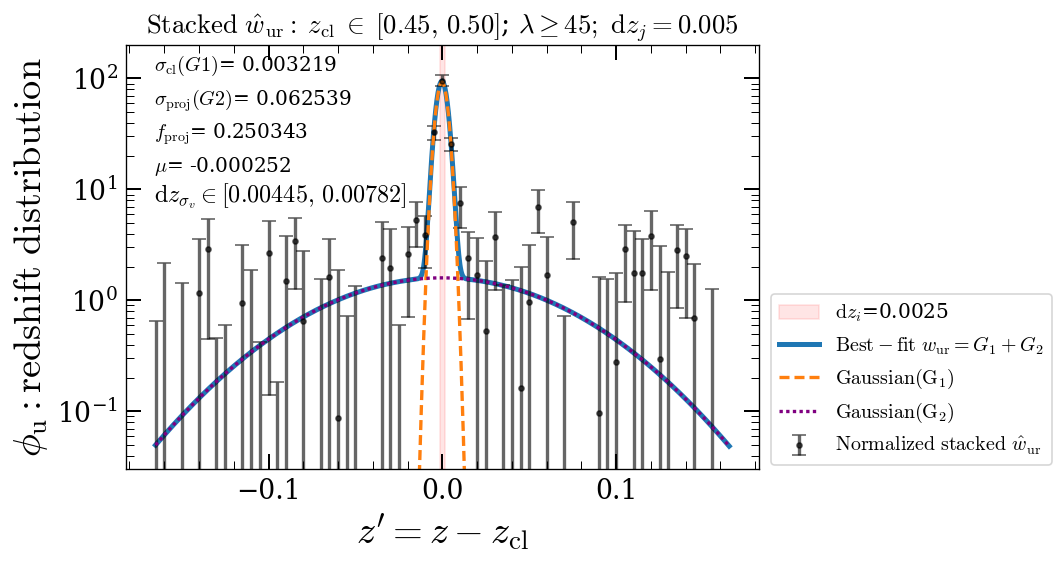

In [8]:
def twoGaussian_func(x, mu, sigma, sigma2, amp2):
    G1 = (1-amp2) * np.exp((-(x-mu)**2) / (2 * sigma ** 2)) / (sigma*np.sqrt(2*np.pi))
    G2 = amp2 * np.exp((-(x-mu)**2) / (2 * sigma2 ** 2)) / (sigma2*np.sqrt(2*np.pi))
    return G1+G2


def wur_model_gaussian(params, x_z):
    mu1 = params[0] ### gaussian_center
    sigma1 =  params[1] ### gaussian1_scatter
    sigma2 =  params[2] ### gaussian2_sigma
    amp2 =  params[3] ### gaussian2_amplitude
    return twoGaussian_func(x_z, mu1, sigma1, sigma2, amp2)


def Gaussian1(params, x):
    mu = params[0]
    sigma = params[1]
    amp2 = params[3]
    return (1-amp2) * np.exp((-(x-mu)**2) / (2 * sigma ** 2)) / (sigma*np.sqrt(2*np.pi))

def Gaussian2(params, x):
    mu2 = params[0]
    sigma2 = params[2]
    amp2 = params[3]
    return amp2 * np.exp((-(x-mu2)**2) / (2 * sigma2 ** 2)) / (sigma2*np.sqrt(2*np.pi))



fig = plt.figure(figsize=(9,6),dpi=120)

ax = plt.subplot(1, 1, 1)

k = i_dzi 
fxx = zj_cen_skdbins[0,:]

plt.axvspan(-dz_i/2.,dz_i/2.,color='red',alpha=0.1,label=r'$\mathrm{d}z_i$'+f"={dz_i}")

### Gaussian fit

new_x = np.linspace(min(fxx),max(fxx),1000)

yG_fit_err = wur_model_gaussian(result_min.x, new_x)
line5, = plt.plot(new_x, yG_fit_err, '-',lw=3, label=r"$\rm Best-fit \ \it w_{\rm ur}= G_1+G_2$") #+znarrow_bins_cen[int(iz_center_tag[k])]

data_err = np.sqrt(np.clip(np.diag(C_fit), 0, np.inf))

line2 = plt.errorbar(fxx, #jbins_zcen,#[norm_tag], #+znarrow_bins_cen[int(iz_center_tag[k])]
                     wur_mean,#[k,norm_tag],
                     yerr = data_err,#[k,norm_tag],
                     fmt='o',ms=3, alpha=.6, color='black', elinewidth=2, capsize=4,
                     label=r"$\rm Normalized \ stacked \ \it \hat{w}_{\rm ur}$")#"\n" +f" r=[{rmind},{rmaxd:.0f}] Mpc"

line7, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian1(result_min.x, new_x), 
                  ':',lw=2, dashes=(3,1.5),label=r"$\rm Gaussian (G_1)$") #

line8, = plt.plot(new_x, #+znarrow_bins_cen[int(iz_center_tag[k])] 
                  Gaussian2(result_min.x, new_x), 
                  '--',lw=2, dashes=(1,1), color='purple', 
                  label=r"$\rm Gaussian (G_2)$")


plt.plot([-10.,10.],[0.,0.],'k--')
plt.xlim(-0.182,0.182)

plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=16, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()


bf_params = result_min.x #result_2g.params

plt.text(.045, .98, r'$\sigma_{\rm cl}(G1)$'+f'= {round(bf_params[1],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .9, r'$\sigma_{\rm proj}(G2)$'+f'= {round(bf_params[2],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .82, r'$f_{\rm proj}$'+f'= {round(bf_params[3],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

plt.text(.045, .74, r'$\mu$'+f'= {round(bf_params[0],6)}',
        ha='left', va='top', transform=ax.transAxes,fontsize=12)

v1 = float(np.asarray(vp603_dz).reshape(-1)[0])  # first element or your chosen stat
v2 = float(np.asarray(vp1063_dz).reshape(-1)[0])

plt.text(.045, .68,
         rf'$\mathrm{{d}}z_{{\sigma_{{v}}}}\in[{v1:.5f},\,{v2:.5f}]$',
         ha='left', va='top', transform=ax.transAxes, fontsize=14.5)


plt.legend(fontsize=12, ncol=1,loc=[1.02,0.01],markerscale=1)#,loc='upper right'

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 
plt.title(rf"$\rm Stacked \ \it \hat{{w}}_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zmin_i:.2f},\,{zmax_i:.2f}]$"
          +r"; $\lambda \geq 45;~ \mathrm{d}z_j=0.005$",fontsize=16)

plt.ylim(0.03,200.)
plt.yscale('log')
plt.tight_layout(rect=[0.0, 0.0, 1, .8])

## Recheck new cov

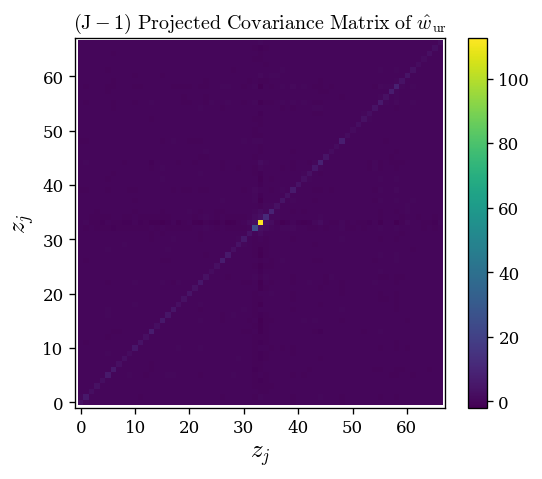

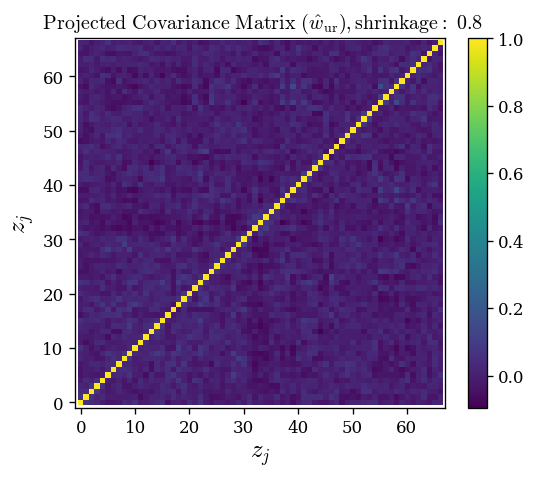

In [9]:

fig, ax = plt.subplots(figsize=(5,4), dpi=120) #plt.figure(figsize=(6,5),dpi=200)

# data_covmat = covariance_matrix
cbar= ax.matshow(C_fit)
# ax.gca().xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.set_xlabel(r'$z_j$', fontsize=15)
ax.set_ylabel(r'$z_j$', fontsize=15)

ax.set_xlim(-1,n_stacking)
ax.set_ylim(-1,n_stacking)
plt.colorbar(cbar, ax=ax)
ax.set_title(r'$\rm (J-1) \ Projected \ Covariance \ Matrix \ of \ \it \hat{w}_{\rm ur}$')
plt.show()


###############################################

fig, ax = plt.subplots(figsize=(5,4), dpi=120) #plt.figure(figsize=(6,5),dpi=200)


data_covmat_norm = normalize_diagonal(C_fit) #covariance_matrix_shrunked
cbar= ax.matshow(data_covmat_norm)
# ax.gca().xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.set_xlabel(r'$z_j$', fontsize=15)
ax.set_ylabel(r'$z_j$', fontsize=15)

ax.set_xlim(-1,n_stacking)
ax.set_ylim(-1,n_stacking)
plt.colorbar(cbar, ax=ax)
ax.set_title(rf'$\rm \ Projected \ Covariance \ Matrix \ \it (\hat{{w}}_{{\rm ur}}), \rm shrinkage: \ {lam}$')
plt.show()

## Run ${\tt emcee.MCMC}$ to explore the posterior space of parameters.

In [10]:
def summarize_chain(arr):
    med = np.median(arr, axis=0)
    lo  = np.percentile(arr, 16, axis=0)
    hi  = np.percentile(arr, 84, axis=0)
    sig = 0.5*(hi-lo)
    return med, sig, lo, hi

def chi2_at_params(theta, Cinv):
    mu1, s1, s2, a2 = theta
    model = twoGaussian_func(x, mu1, s1, s2, a2)
    r = (P @ model) - dataP
    return float(r @ (Cinv @ r))

# prior in parameter space
def log_prior(params):
    mu1, s1, s2, a2 = params
    ok = (
        (-0.01 < mu1 < 0.01) and
        (0.001 < s1  < 0.01) and
        (0.02  < s2  < 0.16)  and
        (0.01  < a2  < 1.0)
    )
    return 0.0 if ok else -np.inf

# Sellentin–Heavens t-likelihood using same C_fit
def log_like_t(params):
    mu1, s1, s2, a2 = params
    model = twoGaussian_func(x, mu1, s1, s2, a2)
    r = (P @ model) - dataP
    chi2 = r @ (Cinv_fit @ r)
    return -0.5 * K * np.log1p(chi2 / (K - 1))

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like_t(params)


def run_chain_t_with_C(C, start_params, nwalkers=200, nsteps=30000, burn=5000, seed=42):
    Cinv = np.linalg.inv(C)

    def log_like_t(params):
        r = (P @ twoGaussian_func(x, *params)) - dataP
        chi2 = r @ (Cinv @ r)
        # Sellentin–Heavens t-likelihood
        return -0.5 * K * np.log1p(chi2 / (K - 1))

    def log_prob(params):
        lp = log_prior(params)
        if not np.isfinite(lp): return -np.inf
        return lp + log_like_t(params)

    rng = np.random.default_rng(seed)
    p0 = start_params + 1e-4 * rng.standard_normal(size=(nwalkers, len(start_params)))
    sampler = emcee.EnsembleSampler(nwalkers, len(start_params), log_prob)
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler.get_chain(discard=burn, flat=True)


# effective dof in projected space
J_eff = J - 1
npar  = 4
dof   = max(J_eff - npar, 1)


In [11]:
# --------------------------------------------------------------------------------
# Run MCMC
# --------------------------------------------------------------------------------

rand_seed = 4273629
nwalkers, nsteps, burn = 200, 60000, 5000
rng = np.random.default_rng(rand_seed)
p0 = best_fit_params + 1e-4 * rng.standard_normal(size=(nwalkers, len(best_fit_params)))
ndim = len(best_fit_params)

# # If save MCMC chain
posterior_path = "/projects/lyang4/projection_effects/cluster_cosmology/new_wur_jk/mcmc_newmatrix/LRGs/"
np.seterr(all="ignore")
backend = emcee.backends.HDFBackend(posterior_path+"twoG_fit_zi4_newcov_lam4_example.h5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, backend=backend)
sampler.run_mcmc(p0, nsteps, progress=True)

# # READ MCMC chain
# # import emcee, numpy as np
# backend = emcee.backends.HDFBackend(posterior_path+"twoG_fit_zi4_newcov_lam4_example.h5", read_only=True)
# sampler = emcee.EnsembleSampler(backend.shape[0], backend.shape[1], log_prob, backend=backend)

# If not save MCMC chain
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
# sampler.run_mcmc(p0, nsteps, progress=True)

chain = sampler.get_chain(discard=burn, flat=True)   # shape [Nsamp, 4]

label = f"t, λ={lam:.2f}"

med, sig, lo, hi = summarize_chain(chain)
chi2_med = chi2_at_params(med, Cinv_fit)
redchi2  = chi2_med / dof

summaries  = []

summaries.append({
    "label": label,
    "lambda": lam,
    "mu_med": med[0],     "mu_sig": sig[0],
    "sigma_med": med[1],  "sigma_sig": sig[1],
    "sigma2_med": med[2], "sigma2_sig": sig[2],
    "amp2_med": med[3],   "amp2_sig": sig[3],
    "reduced_chi2": redchi2
})

print("\nSummary (sigma2, amp2, reduced χ²):")
print("{:<18s} {:>22s} {:>22s} {:>10s}".format(
    "run", "sigma2", "amp2", "red χ²"
))
for s in summaries:
    sig2_str = f'{s["sigma2_med"]:.6g} ± {s["sigma2_sig"]:.6g}'
    a2_str   = f'{s["amp2_med"]:.6g} ± {s["amp2_sig"]:.6g}'
    rchi_str = f'{s["reduced_chi2"]:.3f}'
    print("{:<18s} {:>22s} {:>22s} {:>10s}".format(
        s["label"], sig2_str, a2_str, rchi_str
    ))

# Summary (sigma2, amp2, reduced χ²):
# run                                sigma2                   amp2     red χ²
# t, λ=0.80           0.0584482 ± 0.0376389   0.252336 ± 0.0671155      1.108

100%|██████████| 60000/60000 [11:41<00:00, 85.53it/s]



Summary (sigma2, amp2, reduced χ²):
run                                sigma2                   amp2     red χ²
t, λ=0.80            0.0581374 ± 0.037553   0.251987 ± 0.0667826      1.107


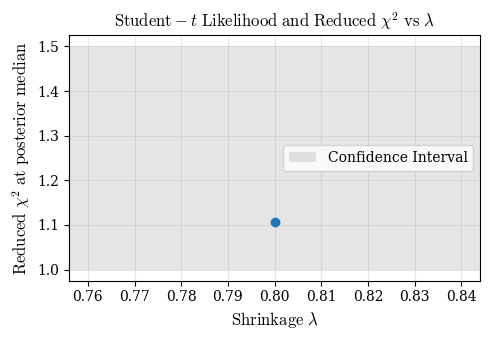

In [50]:

lam_vals, rchis = [], []
for s in summaries:
        lam_vals.append(s["lambda"])
        rchis.append(s["reduced_chi2"])

lam_vals = np.array(lam_vals) 
rchis = np.array(rchis)
ix = np.argsort(lam_vals)
lam_vals, rchis = lam_vals[ix], rchis[ix]

plt.figure(figsize=(5,3.5))
plt.plot(lam_vals, rchis, marker='o')
plt.axhspan(ymin=1.0, ymax=1.5, facecolor='black', 
            alpha=0.1, label='Confidence Interval')
plt.legend()
plt.xlabel(r"$\rm Shrinkage ~\lambda$", fontsize=12)
plt.ylabel(r"$\rm Reduced ~ \chi^2 \  at \ posterior \ median$", fontsize=12)
plt.title(r"$\rm Student-\it t~ \rm Likelihood \ and ~Reduced ~\chi^2~ vs ~ \lambda$")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
from emcee.autocorr import AutocorrError

try:
    tau = sampler.get_autocorr_time(quiet=True)
    burn = int(3 * np.max(tau))
    thin = max(1, int(0.5 * np.min(tau)))
except AutocorrError:
    burn, thin = 5000, 50   # conservative fallback

chain = sampler.get_chain(discard=burn, thin=thin, flat=True)  # shape: [Nsamples, 4]
logp  = sampler.get_log_prob(discard=burn, thin=thin, flat=True)

# keep only finite log-prob samples
good = np.isfinite(logp)
chain = chain[good]
logp  = logp[good]

# draw a manageable subset of posterior samples
Nsamp = min(2000, chain.shape[0])         # choose ~1–5k for smooth bands
idx   = np.random.choice(chain.shape[0], size=Nsamp, replace=False)
theta_samps = chain[idx]                   # shape [Nsamp, 4]
par_names = ["mu", "sigma", "sigma2", "amp2"]

# make a plotting grid in z
x_grid = np.linspace(x.min(), x.max(), 400)

# evaluate the model on the grid for each posterior draw (mean model)
phi_grid_samps = np.array([twoGaussian_func(x_grid, *p) for p in theta_samps])
phi_med  = np.median(phi_grid_samps, axis=0)
phi_16   = np.percentile(phi_grid_samps, 16, axis=0)
phi_84   = np.percentile(phi_grid_samps, 84, axis=0)
phi_025  = np.percentile(phi_grid_samps, 2.5, axis=0)
phi_975  = np.percentile(phi_grid_samps, 97.5, axis=0)

# posterior predictive band at the data x (includes data covariance)
# draw correlated noise epsilon ~ N(0, C) and add to the mean model
C = C_fit
# jitter to ensure PD for Cholesky
L = np.linalg.cholesky(C + 1e-12*np.eye(C.shape[0]))
z = np.random.normal(size=(Nsamp, len(x)))
eps = z @ L.T                                        # shape [Nsamp, n_x]
phi_data_mean = np.array([twoGaussian_func(x, *p) for p in theta_samps])
phi_data_pred = phi_data_mean + eps                  # posterior predictive

pred_med  = np.median(phi_data_pred, axis=0)
pred_16   = np.percentile(phi_data_pred, 16, axis=0)
pred_84   = np.percentile(phi_data_pred, 84, axis=0)
pred_025  = np.percentile(phi_data_pred, 2.5, axis=0)
pred_975  = np.percentile(phi_data_pred, 97.5, axis=0)



# Check posterior region of best-fit parameters

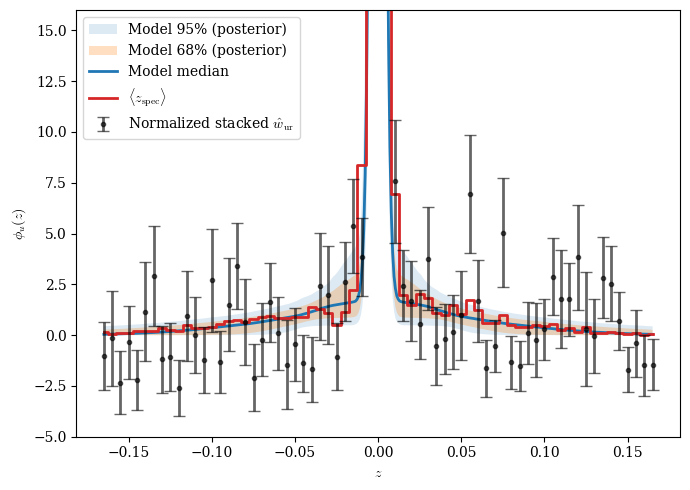

In [13]:

data = wur_mean 

plt.figure(figsize=(7, 5))

plt.fill_between(x_grid, phi_025, phi_975, alpha=0.15, label="Model 95% (posterior)")
plt.fill_between(x_grid, phi_16,  phi_84,  alpha=0.25, label="Model 68% (posterior)")
plt.plot(x_grid, phi_med, lw=2, label="Model median")

plt.step(gal_zj_cen, gal_mean_zjnbins, 
         '-',where='mid',color='#d62728', alpha=1, 
         label = r"$\langle z_{\rm spec}\rangle$",
         lw=2)#,color='#187498')


plt.errorbar(x, 
             data,
             yerr = data_err,
             fmt='o',ms=3, alpha=.6, color='black', elinewidth=2, capsize=4,
             label=r"Normalized stacked $\hat{w}_{\rm ur}$")


# plt.yscale('log')
plt.ylim(-5,16.)
plt.xlabel(r"$z$")
plt.ylabel(r"$\phi_u(z)$")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
from IPython.display import display, Math
labels=[r'$\mu$', r'$\sigma_1$', r'$\sigma_2$', r'$f_{\rm proj}$']

flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
print(flat_samples.shape)

best_fit_mcmc = []
best_fit_mcmc_uperr = []
best_fit_mcmc_lowerr = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    print(mcmc[1])
    best_fit_mcmc.append(mcmc[1])
    best_fit_mcmc_lowerr.append(q[0])
    best_fit_mcmc_uperr.append(q[1])


(733200, 4)


<IPython.core.display.Math object>

-0.0002621357340621466


<IPython.core.display.Math object>

0.0032309880466896163


<IPython.core.display.Math object>

0.058152428203348275


<IPython.core.display.Math object>

0.25205469021703275


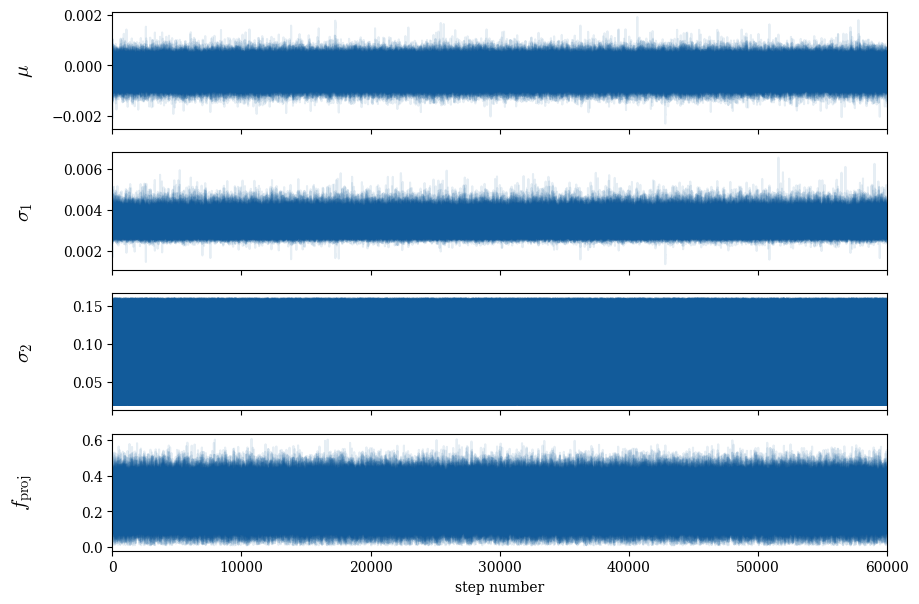

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels=[r'$\mu$', r'$\sigma_1$', r'$\sigma_2$', r'$f_{\rm proj}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "#125B9A", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

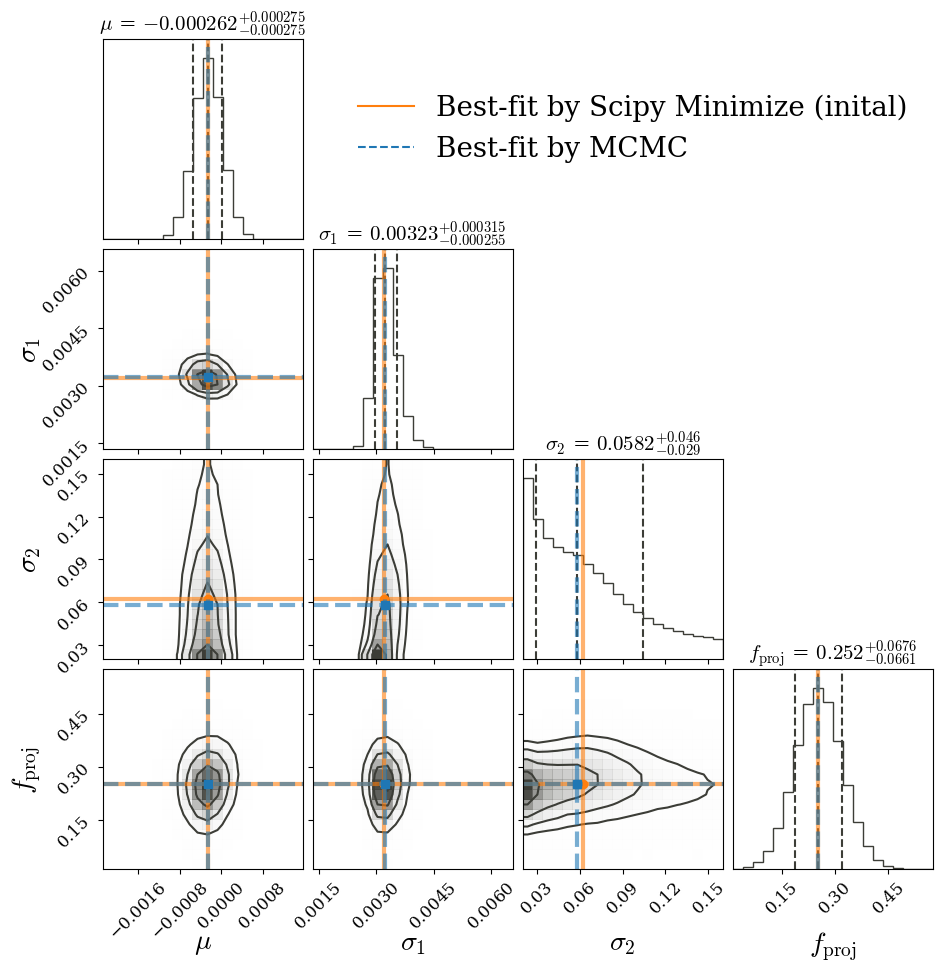

In [16]:
import matplotlib.lines as mlines
import corner


fig = corner.corner(flat_samples, #range=set_xrange, #, bins=50
                    show_titles=True, title_fmt='.3G', title_kwargs={'fontsize':15},
                    labels=[r'$\mu$', r'$\sigma_1$', r'$\sigma_2$', r'$f_{\rm proj}$'],#result_emcee.var_names,
                    use_math_text=True, plot_datapoints=False, color='#3C3D37', #contourf=False, #color='orange', , plot_density=False
                    label_kwargs={'fontsize':20}, quantiles=[0.16, 0.5, 0.84], lw=3); #truths=best_fit_mcmc, 

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)

corner.overplot_lines(fig, best_fit_params, color="#ff7f0e", ls='-',lw=3, alpha=0.6)
corner.overplot_points(fig, best_fit_params[None], marker='o', ms = 6, color="#ff7f0e")

best_fit_mcmc = np.array(best_fit_mcmc)
corner.overplot_lines(fig, best_fit_mcmc, color="#1f77b4", ls='--',lw=3, alpha=0.6)#,dashes=(1,1))
corner.overplot_points(fig, best_fit_mcmc[None], marker='s', ms = 6, color="#1f77b4")

lines = ['-','--']
colors = [ "#ff7f0e", "#1f77b4"]
sample_labels = ['Best-fit by Scipy Minimize (inital)', 'Best-fit by MCMC']
for il in range(2):
    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[il], ls = lines[il], label=sample_labels[il])
            for il in range(2)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right")

    
plt.show()
plt.close()

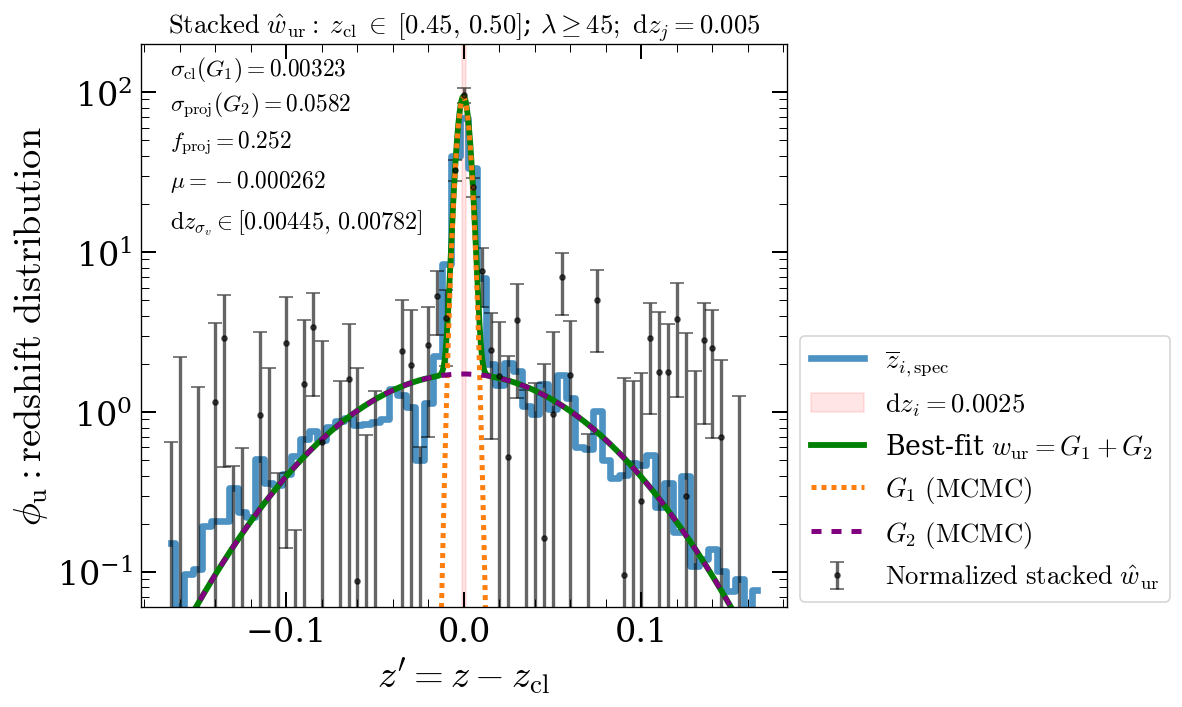

In [29]:
fig = plt.figure(figsize=(10,6),dpi=120)

ax = plt.subplot(1, 1, 1)
k = i_dzi 
 
line1, = plt.step(gal_zj_cen, gal_mean_zjnbins,
                  '-',where='mid',
                  label = r"$\overline{\it z}_{i,\rm spec}$",
                  lw=4,alpha=0.8)#,color='#187498')

plt.axvspan(-dz_i/2.,dz_i/2.,color='red',alpha=0.1,label=rf'$\mathrm{{d}}z_{{i}}={dz_i:.4f}$')

### Double-Gaussian model ###

new_x = np.linspace(min(x),max(x),1000)

line2 = plt.errorbar(x_fit, 
                     data,#[k,norm_tag],
                     yerr = data_err,#[k,norm_tag],
                     fmt='o',ms=3, alpha=.6, color='black', elinewidth=2, capsize=4,
                     label=r"$ \rm Normalized \ stacked \it \ \hat{w}_{\rm ur}$")

yG_fit_err = wur_model_gaussian(best_fit_mcmc, new_x)
line3, = plt.plot(new_x, yG_fit_err, '-',lw=3.5, 
                  color='green',
                  label=r"Best-fit $w_{\rm ur}= G_1+G_2$") 


line4, = plt.plot(new_x, 
                  Gaussian1(best_fit_mcmc, new_x), 
                  ':',lw=3, dashes=(1,1), color='#ff7f0e', 
                  label=r"$G_1\rm \ (MCMC)$") 

line5, = plt.plot(new_x,
                  Gaussian2(best_fit_mcmc, new_x), 
                  '--',lw=3, dashes=(2,2), color='purple',
                  label=r"$G_2 \rm \ (MCMC)$")

plt.plot([-10.,10.],[0.,0.],'k--')
plt.xlim(-0.182,0.182)
plt.ylim(0.06,200.)
plt.yscale('log')



plt.text(.045, .98, rf'$\sigma_{{\rm cl}}(G_1) = {best_fit_mcmc[1]:.5f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)

plt.text(.045, .92, rf'$\sigma_{{\rm proj}}(G_2) = {best_fit_mcmc[2]:.4f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)

plt.text(.045, .85, rf'$f_{{\rm proj}} = {best_fit_mcmc[3]:.3f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)

plt.text(.045, .78, rf'$\mu= {best_fit_mcmc[0]:.6f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)


v1 = float(np.asarray(vp603_dz).reshape(-1)[0])  # first element or your chosen stat
v2 = float(np.asarray(vp1063_dz).reshape(-1)[0])

plt.text(.045, .71,
         rf'$\mathrm{{d}}z_{{\sigma_{{v}}}}\in[{v1:.5f},\,{v2:.5f}]$',
         ha='left', va='top', transform=ax.transAxes, fontsize=14.5)


plt.legend(fontsize=16, ncol=1,loc=[1.02,0.01],markerscale=1)#,loc='upper right'

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 
plt.title(rf"$\rm Stacked \ \it \hat{{w}}_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zmin_i:.2f},\,{zmax_i:.2f}]$"
          +r"; $\lambda \geq 45;~ \mathrm{d}z_j=0.005$",fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=20, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()
plt.tight_layout()

# plt.tight_layout(rect=[0.0, 0.0, 1, .8])

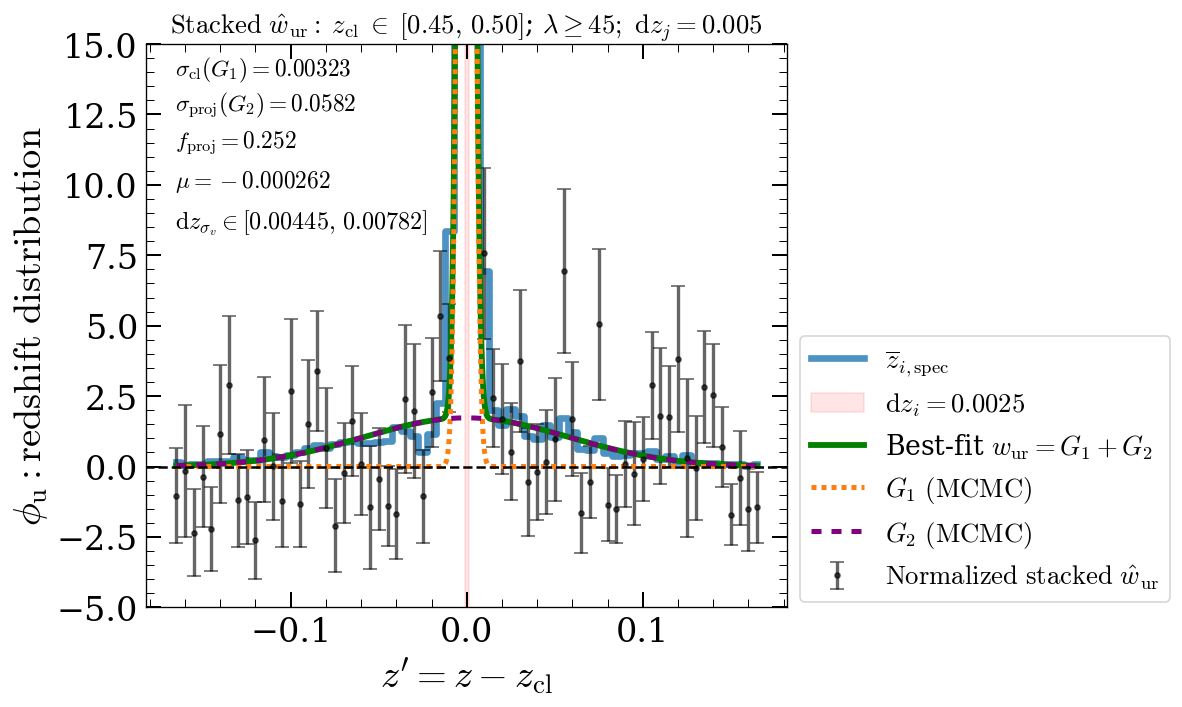

In [28]:
fig = plt.figure(figsize=(10,6),dpi=120)

ax = plt.subplot(1, 1, 1)
k = i_dzi 
 
line1, = plt.step(gal_zj_cen, gal_mean_zjnbins,
                  '-',where='mid',
                  label = r"$\overline{\it z}_{i,\rm spec}$",
                  lw=4,alpha=0.8)#,color='#187498')

plt.axvspan(-dz_i/2.,dz_i/2.,color='red',alpha=0.1,label=rf'$\mathrm{{d}}z_{{i}}={dz_i:.4f}$')

### Double-Gaussian model ###

new_x = np.linspace(min(x),max(x),1000)


line2 = plt.errorbar(x_fit, 
                     data,#[k,norm_tag],
                     yerr = data_err,#[k,norm_tag],
                     fmt='o',ms=3, alpha=.6, color='black', elinewidth=2, capsize=4,
                     label=r"$ \rm Normalized \ stacked \it \ \hat{w}_{\rm ur}$")

yG_fit_err = wur_model_gaussian(best_fit_mcmc, new_x)
line3, = plt.plot(new_x, yG_fit_err, '-',lw=3.5, 
                  color='green',
                  label=r"Best-fit $w_{\rm ur}= G_1+G_2$") 


line4, = plt.plot(new_x, 
                  Gaussian1(best_fit_mcmc, new_x), 
                  ':',lw=3, dashes=(1,1), color='#ff7f0e', 
                  label=r"$G_1\rm \ (MCMC)$") 

line5, = plt.plot(new_x,
                  Gaussian2(best_fit_mcmc, new_x), 
                  '--',lw=3, dashes=(2,2), color='purple',
                  label=r"$G_2 \rm \ (MCMC)$")

plt.plot([-10.,10.],[0.,0.],'k--')
plt.xlim(-0.182,0.182)
plt.ylim(-5, 15.0)
# plt.yscale('log')



plt.text(.045, .98, rf'$\sigma_{{\rm cl}}(G_1) = {best_fit_mcmc[1]:.5f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)

plt.text(.045, .92, rf'$\sigma_{{\rm proj}}(G_2) = {best_fit_mcmc[2]:.4f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)

plt.text(.045, .85, rf'$f_{{\rm proj}} = {best_fit_mcmc[3]:.3f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)

plt.text(.045, .78, rf'$\mu= {best_fit_mcmc[0]:.6f}$',
        ha='left', va='top', transform=ax.transAxes,fontsize=14)


v1 = float(np.asarray(vp603_dz).reshape(-1)[0])  # first element or your chosen stat
v2 = float(np.asarray(vp1063_dz).reshape(-1)[0])

plt.text(.045, .71,
         rf'$\mathrm{{d}}z_{{\sigma_{{v}}}}\in[{v1:.5f},\,{v2:.5f}]$',
         ha='left', va='top', transform=ax.transAxes, fontsize=14.5)


plt.legend(fontsize=16, ncol=1,loc=[1.02,0.01],markerscale=1)#,loc='upper right'

plt.xlabel(r"$z^\prime=z-z_{\rm cl}$",fontsize=23)
plt.ylabel(r'$\phi_{\rm u}:\rm redshift~distribution$',fontsize=23) 
plt.title(rf"$\rm Stacked \ \it \hat{{w}}_{{\rm ur}}: \; z_{{\rm cl}}\;\in\;[{zmin_i:.2f},\,{zmax_i:.2f}]$"
          +r"; $\lambda \geq 45;~ \mathrm{d}z_j=0.005$",fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=8, length=5, width=.6,top=True, right=True,direction='in')
plt.tick_params(axis='both', which='major', labelsize=20, length=9., width=1.2, pad=5,top=True, right=True,direction='in')
plt.minorticks_on()
plt.tight_layout()

# plt.tight_layout(rect=[0.0, 0.0, 1, .8])

# Option: save the best-fit parameters

In [19]:
# # ───── save ─────
# outfile = f"bestfit_params/best_fit_mcmc_params_lherrs_zi_4_lam4_v2.h5"
# print('outfile', outfile)
# with h5py.File(outfile, "w") as h5:
#     h5.create_dataset("best_fit_mcmc", data=best_fit_mcmc)
#     h5.create_dataset("err_lower",  data=best_fit_mcmc_lowerr)
#     h5.create_dataset("err_upper",  data=best_fit_mcmc_uperr)
#     h5.attrs["shrink_lam"] = lam
#     h5.attrs["reduced_chi2"] = redchi2
#     h5.close()
# print("[done] wrote", outfile)

# with h5py.File(outfile, "r") as all_dat:
#     bf_mcmc   = all_dat['best_fit_mcmc'][:]
#     bf_lowerr = all_dat['err_lower'][:]
#     bf_uperr  = all_dat['err_upper'][:]
#     slam      = all_dat.attrs['shrink_lam']
#     chi2_red  = all_dat.attrs['reduced_chi2']
